In [ ]:
!pip install mne

import scipy.io
from io import BytesIO
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mne.decoding import CSP

In [ ]:
mat = scipy.io.loadmat('Walk.mat')
mat
ecog_data = mat['y']

In [ ]:
paradigmInfo = scipy.io.loadmat('Walk_paradigmInfo.mat')

In [ ]:
with open('Walk_settings.txt') as f:
  settings = f.read()
  print(settings)

fs: 1200/128

CH1: time
CH2-161: ECoG 1-160
CH162: DI (Photodiode Feedback)
CH163: StimCode
CH164: GroupId

no reference


In [ ]:
with open('Walk_paradigm.xml') as f:
  paradigminfo = f.read()
  print(paradigminfo)

<?xml version="1.0" encoding="utf-8"?>
<Data  xmlns="xsd"
           xmlns:ns="http://www.w3.org/2001/XMLSchema-instance"
           ns:schemaLocation="xsd C:\_SVN\ECoGmeToo\trunk\sources\ParadigmTools\src\main\Paradigm\ParadigmSchema.xsd">

  <Paradigm BaseFolder="media/">
    <Task ns:type="SingleTask" ID="ST_PreParadigm" DurationSeconds="10">
      <Stimulus ns:type="TextStimulus" Caption="+"/>
    </Task>
    <Task ns:type="SingleTask" ID="ST_Video" DurationSeconds="252" Group="1">
      <Stimulus ns:type="VideoStimulus" FileName="walk.mp4"/>
    </Task>
    <Task ns:type="SingleTask" ID="ST_PostParadigm" DurationSeconds="5">
      <Stimulus ns:type="TextStimulus" Caption="Thank You!"/>
    </Task>
  </Paradigm>

</Data>


# Data exploration


In [ ]:
# VERSION 1: manually labels up to second, depreciated

# labels ={
#     'digit': ['0:10-0:17', '0:36-0:41', '3:51-3:54', '3:59-4:02'], 
#     'kanji': ['0:27-0:36', '3:42-3:46', '3:54-3:56', '4:02-4:04'],
#     'face': ['0:47-0:53', '1:53-2:00', '2:31-2:37', '2:46-2:52', '2:59-3:04', '4:05-4:12'],
#     'hira': ['0:56-1:02'],
#     "object": ['1:25-1:32', '1:53-1:55', '1:59-2:03', '2:10-2:20', '3:12-3:30', '3:48-4:04'],
#     "line": ['1:35-1:40', '3:49-3:51'],
#     "body": ['1:48-2:03', '2:26-2:36', '2:53-3:03', '3:32-3:45', '3:56-3:59']
# }

# for key in labels:

#   key_to_idx = {
#       'body': 0, 
#       'face': 1,
#       'digit': 2,
#       'hira': 3,
#       'kanji': 4,
#       'line': 5,
#       'object': 6,     
#   }

#   for span in labels[key]:
#     start_time, end_time = span.split('-')
#     min, sec = start_time.split(':')
#     start_frame = (int(min) * 60 + int(sec) * 1) * 1200
#     min, sec = end_time.split(':')
#     end_frame = (int(min) * 60 + int(sec) * 1) * 1200
#     print(key, start_frame, end_frame)
#     label_channels[key_to_idx[key]][start_frame:end_frame] = 1

# label_channels = np.zeros((7, 322049))
# label_channels.shape

In [ ]:
# timestamp csv
timestamp_csv = """time,target
00:00:10.567,digit
00:00:27.167,kanji
00:00:36.600,digit
00:00:47.433,face
00:00:56.267,hira
00:01:25.867,toy
00:01:35.433,line
00:01:46.067,body
00:01:52.467,toy
00:01:55.100,face
00:01:59.800,toy
00:02:10.567,toy
00:02:26.300,body
00:02:31.667,face
00:02:46.567,face
00:02:54.333,body
00:03:00.167,face
00:03:12.133,toy
00:03:32.700,body
00:03:42.267,kanji
00:03:50.700,line
00:03:51.433,digit
00:03:54.033,kanji
00:03:56.767,body
00:03:59.433,digit
00:04:02.300,kanji
00:04:05.067,face"""

with open('timestamp.csv', 'w') as f:
  f.write(timestamp_csv)

In [ ]:
import csv

key_to_idx = {
      'body': 0, 
      'face': 1,
      'digit': 2,
      'hira': 3,
      'kanji': 4,
      'line': 5,
      'object': 6,     
  }

with open('timestamp.csv', newline='') as csvfile:
    # Create a CSV reader object
    csvreader = csv.reader(csvfile, delimiter=',')

    # Loop through each row in the CSV file
    for row in csvreader:
        # Access the data in each column of the row
        column1 = row[0]
        if column1 == 'time':
          continue
        _, min, sec = column1.split(':')
        sec, ms = sec.split('.')
        start_frame = int(min) * 60 * 1200 + int(sec) * 1200 + int(int(ms)/1000 * 1200)

        column2 = row[1]

        print(start_frame, column2)

12680 digit
32600 kanji
43920 digit
56919 face
67520 hira
103040 toy
114519 line
127280 body
134960 toy
138120 face
143760 toy
156680 toy
175560 body
182000 face
199880 face
209199 body
216200 face
230559 toy
255240 body
266720 kanji
276840 line
277719 digit
280839 kanji
284120 body
287319 digit
290760 kanji
294080 face


# Auto annotation experinment

In [ ]:
# pip install git+https://github.com/facebookresearch/segment-anything.git

In [ ]:
# pip install opencv-python pycocotools matplotlib onnxruntime onnx

In [ ]:
# ! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
# from segment_anything import SamPredictor, sam_model_registry
# sam = sam_model_registry["default"](checkpoint="/content/sam_vit_h_4b8939.pth")
# predictor = SamPredictor(sam)

# import cv2
# from segment_anything import SamAutomaticMaskGenerator

# mask_generator = SamAutomaticMaskGenerator(sam)

# image_bgr = cv2.imread('/content/frames/frame_000000.jpg')
# image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
# result = mask_generator.generate(image_rgb)

In [ ]:
import cv2
import os

input_file = 'walk.mp4'
output_dir = 'frames'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

cap = cv2.VideoCapture(input_file)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)

In [ ]:
# Loop through each frame and extract the ones that meet the condition
frame_number = 0
while True:
    # Read the next frame
    ret, frame = cap.read()
    if not ret:
        break

    # Check if the current frame meets the condition
    time_stamp = int(cap.get(cv2.CAP_PROP_POS_MSEC))
    if time_stamp % 100 == 0:
        # Save the frame to a file
        output_file = os.path.join(output_dir, f'frame_{time_stamp:06d}.jpg')
        cv2.imwrite(output_file, frame)
        frame_number += 1

cap.release()

In [ ]:
! ls frames | wc -l

In [ ]:
pip install transformers

In [ ]:
key_to_idx.keys()

dict_keys(['body', 'face', 'digit', 'hira', 'kanji', 'line', 'object'])

In [ ]:
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
all_probs = []

annotation_keys = ['human body', 'human face', 'digit', 'hira', 'kanji', 'line drawing', 'small toy object', 'grass or tree background']

for idx in range(0, 322049, 200):
  try:
    image_fname = f'/content/frames/frame_{idx:06d}.jpg'
    image = Image.open(image_fname)

    inputs = processor(text=annotation_keys, images=image, return_tensors="pt", padding=True)

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
    all_probs.append(probs.detach().numpy())
  except:
    pass

In [ ]:
all_probs[:3]

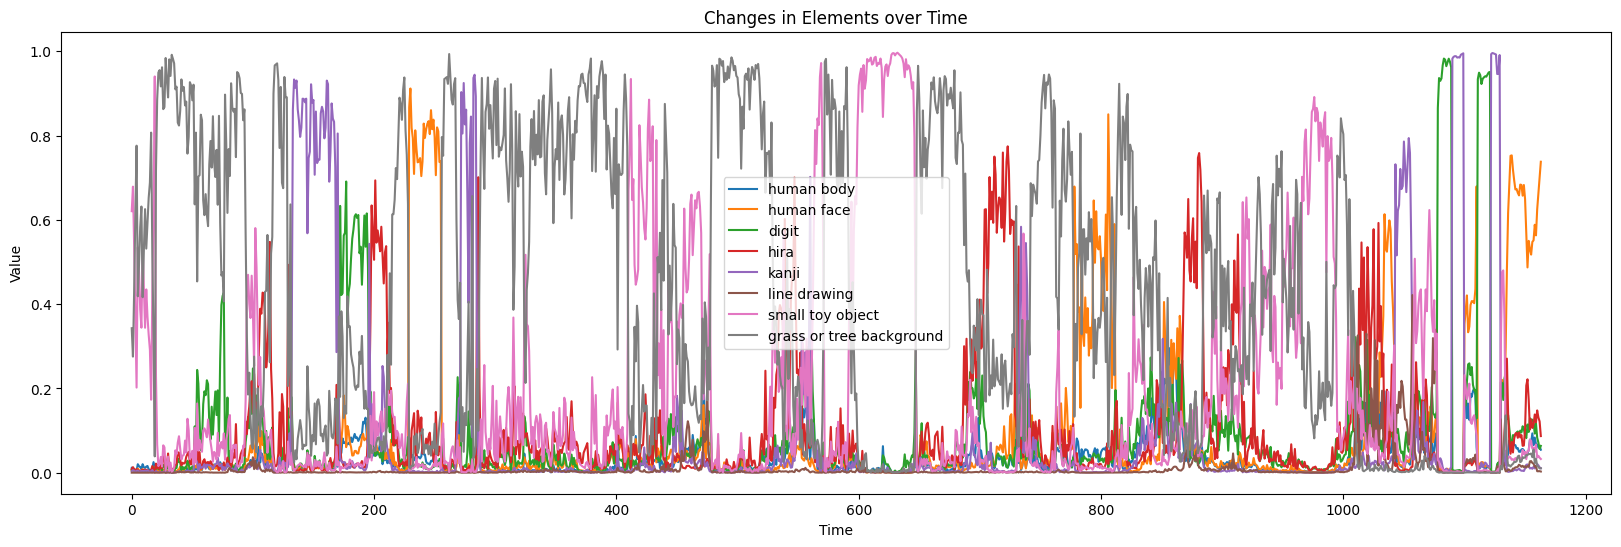

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 6))

for i in range(all_probs[0].shape[1]):
    element_data = [x[0][i] for x in all_probs]
    ax.plot(element_data, label=f'{annotation_keys[i]}')

ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Changes in Elements over Time')
ax.legend()
plt.show()

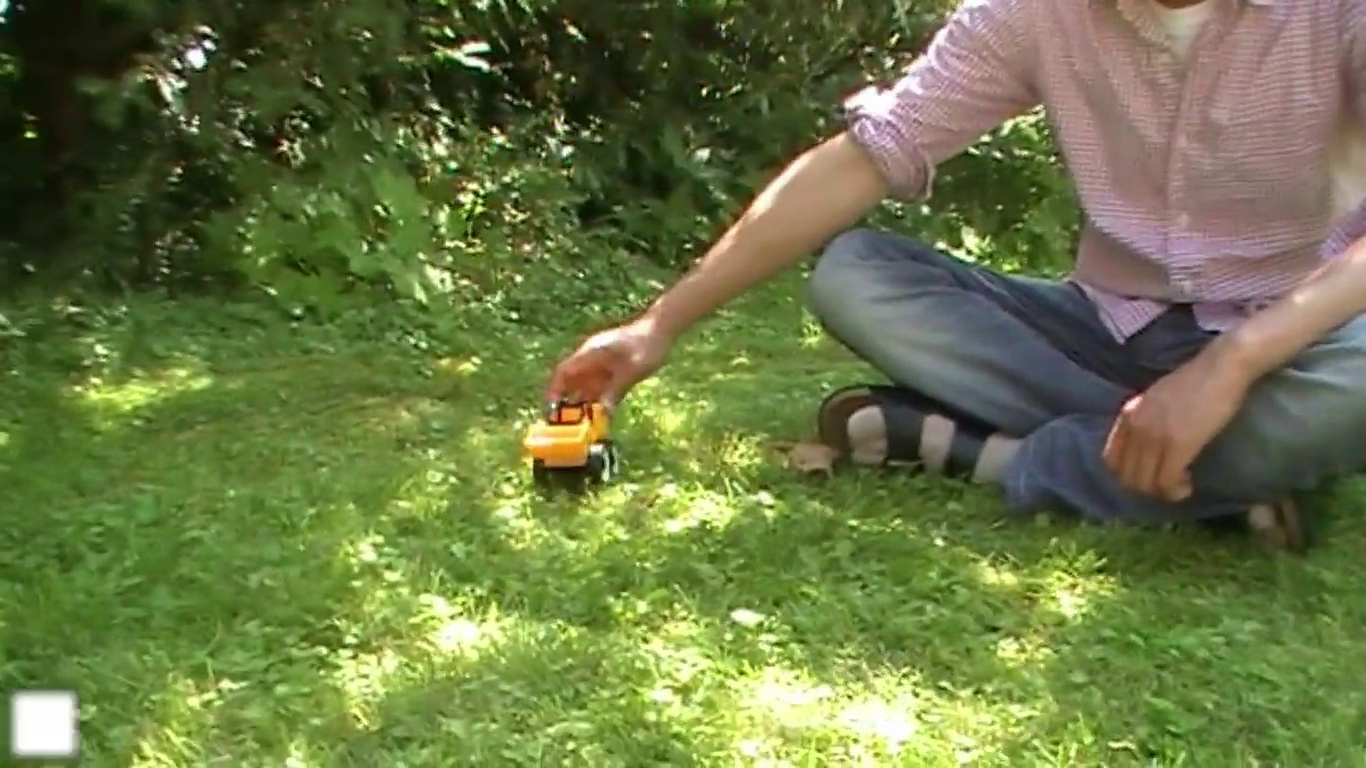

In [ ]:
from IPython.display import Image
filename = image_fname
Image(filename, width=400)

In [ ]:
from transformers import pipeline

image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

image_to_text("/content/frames/frame_002000.jpg")


# Preprocessing 

In [ ]:
# get the indices of the columns where the last row is 1
video_indices = np.where(ecog_data[-1] == 1)[0]
video_data = ecog_data[:, video_indices]
stim_1_data = ecog_data[:, np.where(ecog_data[-2] == 1)[0]]
stim_2_data = ecog_data[:, np.where(ecog_data[-2] == 2)[0]]
stim_3_data = ecog_data[:, np.where(ecog_data[-2] == 3)[0]]

In [ ]:
x = video_data[1:161]

In [ ]:
import csv

key_to_idx = {
      'body': 0, 
      'face': 1,
      'digit': 2,
      'hira': 3,
      'kanji': 4,
      'line': 5,
      'toy': 6,     
  }

samples = []

# Open the CSV file for reading
with open('timestamp.csv', newline='') as csvfile:
    # Create a CSV reader object
    csvreader = csv.reader(csvfile, delimiter=',')

    # Loop through each row in the CSV file
    for row in csvreader:
        # Access the data in each column of the row
        column1 = row[0]
        if column1 == 'time':
          continue
        _, min, sec = column1.split(':')
        sec, ms = sec.split('.')
        start_frame = int(min) * 60 * 1200 + int(sec) * 1200 + int(int(ms)/1000 * 1200)

        target_class = row[1]

        # Do something with the data, such as printing it to the console
        samples.append((start_frame, target_class))

In [ ]:
full_X_subset = []
full_Y_labels = []

for sample in samples:

  onset_frame, target_class = sample

  start_frame = onset_frame
  end_frame = start_frame + int(float(600 / 1000) * 1200)
  full_X_subset.append(x[:,start_frame:end_frame])
  full_Y_labels.append((target_class, key_to_idx[target_class]))

In [ ]:
import pickle

with open('full_Y_labels.pickle', 'wb') as f:
    # Serialize the object and write it to the file
    pickle.dump(full_Y_labels, f)

with open('full_X_subset.pickle', 'wb') as f:
    # Serialize the object and write it to the file
    pickle.dump(full_X_subset, f)

In [ ]:
from google.colab import files
files.download('/content/full_X_subset.pickle')
files.download('/content/full_Y_labels.pickle')

In [ ]:
# Implement bandpass filter to isolate broadband gamma activity 
fs = 1200

#110-140
low_pass_freq = 110
high_pass_freq = 140
filter_order = 4
nyq_freq = 0.5*fs

b, a = signal.butter(filter_order, [low_pass_freq / nyq_freq, high_pass_freq / nyq_freq], btype='bandpass')

x_filt = signal.filtfilt(b,a,x, axis=1)

In [ ]:
# prepped_data: Data needs to be in (trial, channel, sample) format where each trial has the same number of samples 
# Labels need to be in a separate vector of length (trial) with a number corresponding to the type of stimulus (face, letters, digits, etc)

num_classes = len(np.unique(labels))

csp_list = []
lda_list = [] 

for class_number in range(num_classes):
  labels_binary = np.zeros(labels.shape)
  labels_binary[labels == class_number] = 1
  labels_binary[labels != class_number] = -1

  #Fit pipeline to data
  csp = CSP(n_components=4, reg=None, log=None, norm_trace=False)
  lda = LDA()
  clf = Pipeline([('CSP', csp), ('LDA', lda)])
  clf.fit(prepped_data, labels_binary)

  #Save for later
  csp_list.append(csp)
  lda_list.append(lda)


In [ ]:
csp_filtered_data_list = []

for csp in csp_list:
  csp_data = csp.transform(prepped_data)
  csp_filtered_data_list.append(csp_data)

#combine all data
final_data = np.concatenate(csp_filtered_data_list, axis=-1)


In [ ]:
#IGNORE THIS CELL

#CSP attempt 1 - going to try again using MNE library 

def get_csp(data, labels, n_components): 
  num_classes = len(np.unique(labels))
  #Get class means
  class_means = [np.mean(data[labels == class_num], axis=0) for class_num in np.unique(labels)]

  #Compute spatial covariance matrices for each class
  covs = [np.cov(data[labels == class_num], rowvar=False) for class_num in np.unique(labels)]

  #Get eigenval problem for cov
  _, V = eigh(covs[0], covs[0] + covs[1] + covs[2])
  V = V[:,::-1]     #Sort by descending eigenvalue

  filters = []
  for i in range(num_classes):
      class_i = i
      other_classes = np.setdiff1d(np.arange(num_classes), class_i)
      class_data = data[labels == class_i]
      other_class_data = data[np.isin(labels, other_classes)]
      cov_i = np.cov(class_data.reshape(-1, class_data.shape[-1]), rowvar=False)
      cov_other_classes = np.cov(other_class_data.reshape(-1, other_class_data.shape[-1]), rowvar=False)
      _, V = eigh(cov_i, cov_i + cov_other_classes)
      V = V[:, ::-1]
      W = np.dot(V.T, np.vstack([np.eye(data.shape[1]), np.eye(data.shape[1])]))
      norms = np.sqrt(np.sum(W ** 2, axis=0))
      W /= norms
      filters.append(W)
  return filters

# Classification

In [ ]:
import pickle
import numpy as np

with open('full_X_subset_v2.pickle', 'rb') as f:
  data_list = pickle.load(f)

x = np.stack(data_list)
x.shape

with open('full_Y_labels_v2.pickle', 'rb') as f:
  labels_list = pickle.load(f)

label_names = [tup[0] for tup in labels_list]
labels = [tup[1] for tup in labels_list]

labels = np.array(labels)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Reshape the input data
X = x.reshape((27, -1))
y = labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create a k-NN classifier and fit it to the training data
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(X_train, y_train)

# Use the classifier to predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the classifier's performance on the test data
train_accuracy = clf.score(X_train, y_train)
print(f"Train_accuracy: {train_accuracy:.2f}")

accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
def load_method(method='RF'):
    if method == 'RF':
        clf = RandomForestClassifier(max_depth=4)
    if method == 'SVM':
        clf = svm.SVC(kernel='linear', C=0.5, probability=True)
    if method == 'SVM_rbf':
        clf = svm.SVC(kernel='rbf', C=0.5, probability=True)
    if method == 'AdaBoost':
        base_estimator = RandomForestClassifier(max_depth=4)
        clf = AdaBoostClassifier(base_estimator=base_estimator,n_estimators=20,learning_rate=0.1)
    if method == 'XGBoost':
        clf = XGBClassifier(n_estimators=20)
    return clf

In [ ]:
from xgboost import XGBClassifier

def train_ml(x,labels, seed=86):

    # Reshape the input data
    X = x.reshape((27, -1))
    y = labels

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

    # Create a k-NN classifier and fit it to the training data
    # clf = KNeighborsClassifier(n_neighbors=2)
    clf = XGBClassifier()
    clf.fit(X_train, y_train)

    # Use the classifier to predict the labels for the test data
    y_pred = clf.predict(X_test)

    # Evaluate the classifier's performance on the test data
    train_accuracy = clf.score(X_train, y_train)
    print(f"Train_accuracy: {train_accuracy:.2f}")

    accuracy = clf.score(X_test, y_test)
    print(f"Accuracy: {accuracy:.2f}")

    return clf

train_ml(x,labels)

Train_accuracy: 1.00
Accuracy: 0.67


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
from tensorflow.keras import layers, models

# Define the input shape
input_shape = (160, 720, 1)

# Define the model architecture
model = models.Sequential([
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x, labels, epochs=50, validation_split=0.1, verbose=2)

In [ ]:
# Prepare the input data
x_test = x.reshape((27, 160, 720, 1))
x_test = x_test.astype('float32') / 255.0

# Make predictions using the model
y_pred = model.predict(x_test)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Print the predicted labels
print(y_pred_labels)

In [ ]:
!pip install shap

import xgboost
from sklearn.decomposition import PCA

def train_shap(x,labels):
    import xgboost
    # X, y = shap.datasets.boston()
    from sklearn.decomposition import PCA
    pca = PCA(n_components=1)
    X = []
    for sub_x in x:
        sub_x = pca.fit_transform(sub_x)
        X.append(sub_x)
    X = np.array(X)
    X = X.reshape((27, -1))
    y = labels
    print(X.shape)

    import pandas as pd
    X = pd.DataFrame(X,columns=['Channel %d'%c for c in range(160)])

    label_names = ['Body','Face','Digit','Hira', 'Kanji', 'Line', 'Object']

    model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    print(X.shape)
    print(shap_values.shape)

    unique_y = np.unique(y)

    for i in range(len(unique_y)):
        plt.figure(figsize=(5,3))
        label_name = label_names[unique_y[i]]
        plt.title(f"{label_name}", fontsize=25)
        idx = [ii for ii in range(len(y)) if y[ii] == unique_y[i]]
        plt.tight_layout()
        shap.summary_plot(shap_values[idx, :], X.iloc[idx, :])

    shap_interaction_values = explainer.shap_interaction_values(X)
    shap.summary_plot(shap_interaction_values, X)

show_shap(x,labels)